<a href="https://colab.research.google.com/github/gnganesh99/BO-for-AutoSTM/blob/main/Workflow_DKL_STM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Workflow model for the Deep Kernel Learning implemented on STM.

Refs:

1. Narasimha, Ganesh, et al. "Multiscale structure-property discovery via active learning in scanning tunneling microscopy." arXiv preprint arXiv:2404.07074 (2024).

2. Wilson, Andrew Gordon, et al. "Deep kernel learning." Artificial intelligence and statistics. PMLR, 2016.

3. https://github.com/gnganesh99/DKL_on_STM

# Install and Import packages

In [ ]:
! pip install gpax
! pip install atomai
!pip install sidpy

In [ ]:
from warnings import filterwarnings

import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import os

from scipy.signal import find_peaks
from sklearn.model_selection import train_test_split

import gpax
from atomai.utils import get_coord_grid, extract_patches_and_spectra, extract_patches, extract_subimages
import atomai as aoi
import gdown

import cv2
import random



import os
import numpy as np
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sidpy


gpax.utils.enable_x64()

# Functions

In [ ]:
def plot_DKL_prediction(obj_mean, obj_var, obj, indices_test, indices_m, y_measured):
    '''
    Plots the objective-mean, variance and the acquisiion function across the sample region
    '''

    fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (15,5))

    fig.tight_layout(pad = 7)
    next_coord = indices_test[obj.argmax()]
    indices = indices_all
    a = ax[0].scatter(indices[:,1], indices[:,0], c=obj_mean, cmap='viridis', linewidth=5)
    ax[0].scatter(indices_m[:,1], indices_m[:,0], marker='s', c=y_measured, cmap='jet', linewidth=0.2)
    ax[0].scatter(next_coord[1], next_coord[0], marker='x', c='r')
    #ax[0].scatter(X_opt_GP[0, 0], X_opt_GP[0, 1], marker='o', c='r')
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(a, cax=cax, orientation='vertical')
    ax[0].set_title('Objective mean map', fontsize=10, pad = 14)

    ax[0].set_xlabel('X')
    ax[0].set_ylabel('Y')
    #ax[0].axes.xaxis.set_visible(False)
    #ax[0].axes.yaxis.set_visible(False)
    #ax[0].colorbar(a)

    b = ax[1].scatter(indices[:,1], indices[:,0], c=obj_var, cmap='viridis', linewidth=5)
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(b, cax=cax, orientation='vertical')
    ax[1].set_title('Objective variance map', fontsize=10, pad = 14)
    ax[1].set_xlabel('X')
    ax[1].set_ylabel('Y')
    #ax[1].axes.xaxis.set_visible(False)
    #ax[1].axes.yaxis.set_visible(False)
    #ax[1].colorbar(b)


    c= ax[2].scatter(indices_test[:, 1], indices_test[:, 0], c=obj, s = 50)
    ax[2].scatter(next_coord[1], next_coord[0], marker='x', c='k')
    ax[2].set_title("Acquisition function values")
    #divider = make_axes_locatable(ax[2])
    #cax = divider.append_axes('right', size='5%', pad=0.05)

    plt.show()

def normalize_0to1(array):
    '''
    Returns the normalized array in range 0-1
    '''

    array = np.asarray(array)
    norm_array = (array -  np.min(array))/(np.max(array) - np.min(array))
    return norm_array

def positive_current_area(v, i):

    '''
    Returns the integrated current (or didv) for positive bias sweep, V > 0
    '''
    v_s = []
    curr_s = []
    scalar = 0

    for k in range(len(v)):
        if v[k] > 0:
            v_s.append(v[k])
            curr_s.append(i[k])

    scalar += np.trapz(curr_s, x = v_s)

    return scalar

# Import ground truth data

In [ ]:
# Download ground truth data
!gdown https://drive.google.com/uc?id=15HaspgtaEY47HGbqE6fJrSazCsuGkt9L


Downloading...
From: https://drive.google.com/uc?id=15HaspgtaEY47HGbqE6fJrSazCsuGkt9L
To: /content/cits_metadata_largearea
100% 33.5M/33.5M [00:00<00:00, 35.2MB/s]


Measurements conditions

In [ ]:
# Sample region is 250 nm x 250 nm; grid points = 180 x 180

x_range = np.linspace(0, 2.5E-7, 180)

#Bias sweep in range : -1.5 to 2.5 V, 121 sweep point
V_range = np.linspace(-1.5, 2.5, 121)

In [ ]:
file_name = r"/content/cits_metadata_largearea"
hf = h5py.File(file_name, 'r+')
sidpy.hdf_utils.print_tree(hf)

/
├ Measurement_000
  ---------------
  ├ Current_spectroscopy
    --------------------
    ├ Current_spectroscopy
      --------------------
      ├ Current_spectroscopy
      ├ a
      ├ b
      ├ c
├ Measurement_001
  ---------------
  ├ STM Image
    ---------
    ├ Image
      -----
      ├ Image
      ├ a
      ├ b


## Image data

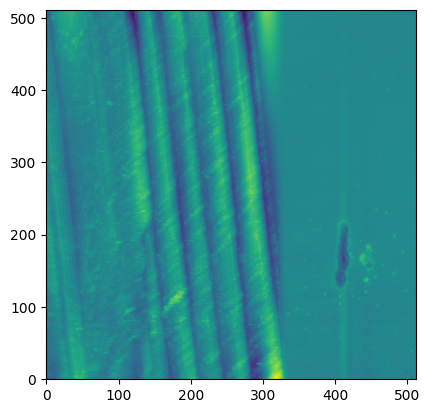

In [ ]:
ds_image = hf["Measurement_001/STM Image/Image/Image"]

#Normalize the morphology image in range 0-1
#ds_image =  normalize_0to1(ds_image)

#Converting to nm
ds_image = np.asarray(ds_image)*1E9
plt.imshow(ds_image, origin='lower')

## CITS ground truth data

In [ ]:
dataset = hf["Measurement_000/Current_spectroscopy/Current_spectroscopy/Current_spectroscopy"]
dataset = np.asarray(dataset)

print('contains current-volatge spectrotroscopy dataset of size:',dataset.shape)

contains current-volatge spectrotroscopy dataset of size: (180, 180, 121)


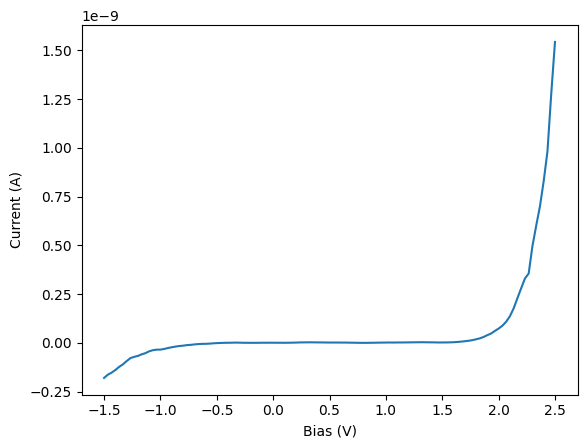

In [ ]:
point_index = [10, 10]

#current spectroscopy at point_index:
i = dataset[point_index[0], point_index[1]]

plt.plot(V_range, i)
plt.xlabel('Bias (V)')
plt.ylabel('Current (A)')
plt.show()

## Scalarizer

Here we introduce the scalarizer as the integration of the I-V spectrum for V>0.
This is given by the function "positive_current_area"

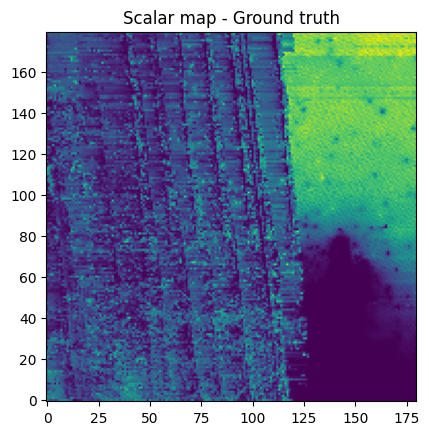

In [ ]:
#scalarized dataset
scalar_ds = np.zeros([dataset.shape[0], dataset.shape[1]])

for i in range(dataset.shape[0]):
  for j in range(dataset.shape[1]):

    current_spectrum  = dataset[i, j, :]
    scalar = positive_current_area(V_range, current_spectrum)
    scalar_ds[i, j] = scalar

plt.imshow(scalar_ds, origin = 'lower')
plt.title("Scalar map - Ground truth")
plt.show()


In [ ]:
hf.close()

# Images for training

features shape =  (2304, 30, 30)
Patch coordinates =  (2304, 2)
Image is fragmented to multiple pathches.
Coordinate at grid index 0 = [20. 20.]
Patch at index 0:



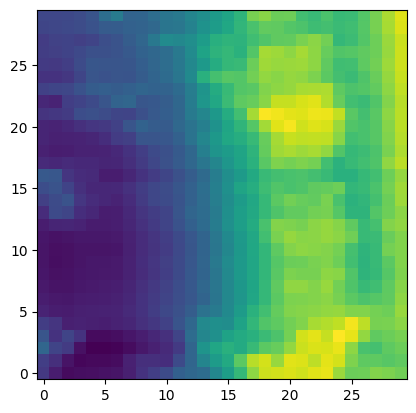

In [ ]:
# Window_size is the width (in pixels) of the patch considered as a feature-example for training
window_size = 30

# Coordinate step is the distance between the center of two adjacent image patches
coordinate_step = 10


coords = get_coord_grid(ds_image, step = coordinate_step, return_dict= False)
indices_all = coords
#print('initial coordinates = ',coords[:, 0].shape)


# Extract patches (or features) and the center coordinates of each patch.
extracted_features = extract_subimages(ds_image, coordinates = coords, window_size = window_size)
patches, coordinates, _ = extracted_features
patches = patches.squeeze()



print('features shape = ',patches.shape)
print('Patch coordinates = ',coordinates.shape)

grid_index = 0
print(f"Image is fragmented to multiple pathches.\nCoordinate at grid index {grid_index} = {coordinates[grid_index]}\nPatch at index {grid_index}:\n")

plt.imshow(patches[grid_index], origin = 'lower')
plt.show()

Prepare train and test sets

In [ ]:
# Reshape patches into 1D vectors
n, d1, d2 = patches.shape
X = patches.reshape(n, d1*d2)

# Reshape ground-truth scalars for one-to-one correlation with the image patches
scalar_dim = int(n**0.5)
data_spec = cv2.resize(scalar_ds,(scalar_dim, scalar_dim))

y = np.reshape(data_spec, (n))
indices_all = coordinates
X.shape, y.shape


((2304, 900), (2304,))

# DKL Implementation - Active learning

Create X_train and y_train which are our measured image patches (from STM topography) and scalars derived from tunneling spectroscopy, respectively.
The indices_train are grid coordinates of the measured points

X_test and y_test are the "unkwown" ones.
The indices_test are the grid coordinates of the remaining available points on the grid

In [ ]:
# Test train split
train_size = 0.1       # 0.1 implies 10 % of data for model training

(X_train, X_test, y_train, y_test, indices_train, indices_test) =  train_test_split(X, y, indices_all, train_size = train_size, shuffle=True, random_state=3)

In [ ]:
y_train.shape

(230,)

Plot train set

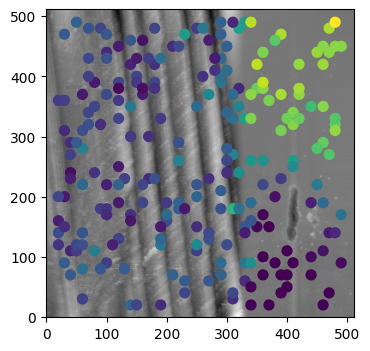

In [ ]:
plt.figure(figsize=(4, 4))
plt.imshow(ds_image, origin ='lower', cmap = 'gray')
plt.scatter(indices_train[:, 1], indices_train[:, 0], s=50, c=y_train)
initial_train = len(y_train)

## Active learning based exploration

In [ ]:
# DKL Implementation - Active learning

exploration_steps = 100


for e in range(exploration_steps):

    print("{}/{}".format(e+1, exploration_steps))

    key1, key2 = gpax.utils.get_keys()
    data_dim = X_train.shape[-1]

    #Normalize train output
    y_train_norm = normalize_0to1(y_train)

    #Train model
    dkl = gpax.viDKL(data_dim, 2, kernel = 'RBF')

    dkl.fit(key1, X_train, y_train_norm, num_steps=100, step_size=0.05)

    # Compute UCB acquisition function with beta annealed in range 10 - 0.001

    power_f = (len(y_train) - initial_train)
    if power_f < 1:
        power_f = 0

    beta_iter = 10 * (0.9**(power_f))

    if beta_iter < 0.001:
        beta_iter = 0.001

    obj = gpax.acquisition.UCB(key2, dkl, X_test, beta=beta_iter, maximize=True)   # you may decrease step size and increase number of steps (e.g. to 0.005 and 1000) for more stable performance

    # DKL prediction
    mean, var = dkl.predict(key2, X)

    # Select next point to "measure"
    next_point_idx = obj.argmax()
    next_point = indices_test[next_point_idx]   # coordinate of the points

    # Do "measurement" - based on ground truth data
    measured_point = y_test[next_point_idx]

    # Plot current result
    plot_DKL_prediction(mean, var, obj, indices_test, indices_train, y_train)

    # Update train and test sets

    X_train = np.append(X_train, np.asarray([X_test[next_point_idx]]), axis = 0)
    X_test = np.delete(X_test, next_point_idx, 0)

    y_train = np.append(y_train, measured_point)
    y_test = np.delete(y_test, next_point_idx)

    indices_train = np.append(indices_train, np.asarray([next_point]), 0)
    indices_test = np.delete(indices_test, next_point_idx, 0)

# Analyze DKL prediction

DKL prediction

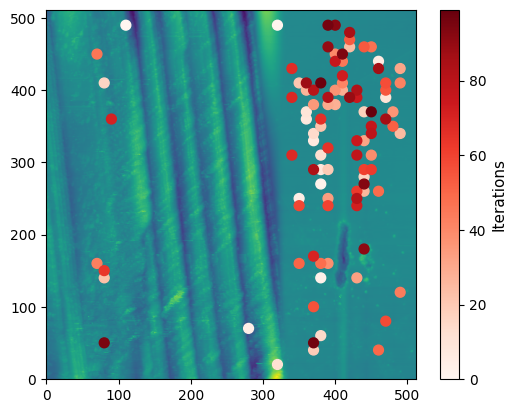

In [ ]:
plt.imshow(ds_image, origin = 'lower')
plt.scatter(indices_train[initial_train:, 1], indices_train[initial_train:, 0], c=np.arange(len(indices_train[initial_train:])), s=50, cmap="Reds")
cbar = plt.colorbar()
cbar.set_label(r"Iterations", size = 11)
plt.show()


DKL scalar map

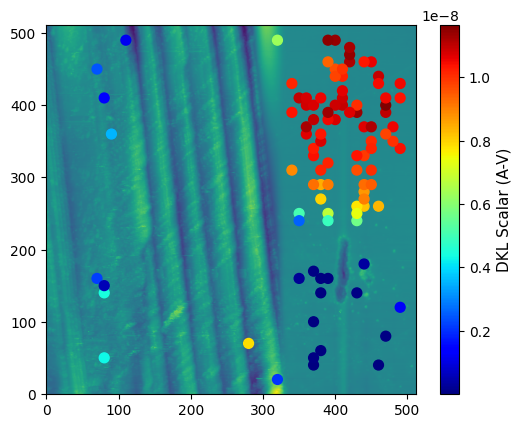

In [ ]:
plt.imshow(ds_image, origin = 'lower')
plt.scatter(indices_train[initial_train:, 1], indices_train[initial_train:, 0], c=y_train[initial_train:], s=50, cmap="jet")
cbar = plt.colorbar()
cbar.set_label(r"DKL Scalar (A-V)", size = 11)
plt.show()